In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
import wandb
from tqdm import tqdm
import os

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(128, 128)):
        self.root_dir = Path(root_dir)
        self.target_size = target_size

        if not self.root_dir.exists():
            raise FileNotFoundError(f"Директория {self.root_dir} не существует")

        self.class_folders = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])

        if not self.class_folders:
            raise ValueError(f"Не найдено папок с классами в {self.root_dir}")

        self.class_names = [folder.name for folder in self.class_folders]
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(target_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_indices = defaultdict(list)

        self._collect_data()

        print(f"Датасет загружен: {len(self.image_paths)} изображений, {len(self.class_names)} классов")

    def _collect_data(self):
        for class_name, class_idx in self.class_to_idx.items():
            class_folder = self.root_dir / class_name / 'images'
            
            image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
            
            if not class_folder.exists():
                 class_folder = self.root_dir / class_name
            
            image_files = [f for f in class_folder.iterdir()
                          if f.suffix.lower() in image_extensions]

            for img_path in image_files:
                idx = len(self.image_paths)
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
                self.class_to_indices[class_idx].append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Ошибка загрузки изображения {img_path}: {e}")
            dummy_image = torch.zeros(3, *self.target_size)
            return dummy_image, label

    def get_class_name(self, label):
        return self.idx_to_class.get(label, "Unknown")

    def split_dataset(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        indices = list(range(len(self)))
        labels = [self.labels[i] for i in indices]

        train_idx, temp_idx = train_test_split(
            indices,
            train_size=train_ratio,
            random_state=random_seed,
            stratify=labels
        )

        val_test_ratio = val_ratio / (val_ratio + test_ratio)
        temp_labels = [self.labels[i] for i in temp_idx]

        val_idx, test_idx = train_test_split(
            temp_idx,
            train_size=val_test_ratio,
            random_state=random_seed,
            stratify=temp_labels
        )

        train_dataset = Subset(self, train_idx)
        val_dataset = Subset(self, val_idx)
        test_dataset = Subset(self, test_idx)

        return train_dataset, val_dataset, test_dataset

In [25]:
class SupervisedTrainer:
    def __init__(self, model, train_loader, val_loader, device, lr, weight_decay):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5)
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'lr': []
        }
        
    def train(self, epochs, experiment_name):
        best_acc = 0.0
        print(f"\nStart Training: {experiment_name}")
        
        for epoch in range(epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0
            pbar = tqdm(self.train_loader, desc=f"Ep {epoch+1}/{epochs}", leave=False)
            
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix({'acc': f"{100.*correct/total:.1f}%"})
            
            epoch_train_loss = train_loss / len(self.train_loader)
            epoch_train_acc = 100. * correct / total
            
            val_loss, val_acc = self.validate()
            self.scheduler.step(val_loss)
            
            self.history['train_loss'].append(epoch_train_loss)
            self.history['train_acc'].append(epoch_train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), f"temp_best_{experiment_name}.pth")
                
        print(f"Finished {experiment_name}. Best Val Acc: {best_acc:.2f}%")
        return self.history, best_acc

    def validate(self):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        return val_loss / len(self.val_loader), 100. * correct / total


In [26]:
dataset = ImageDataset(root_dir=IMBALANCED_DATA_PATH)
    
counts = [len(dataset.class_to_indices[i]) for i in range(len(dataset.class_names))]
print(f"Data Distribution: Max={max(counts)}, Min={min(counts)}")

Датасет загружен: 37322 изображений, 50 классов
Data Distribution: Max=1645, Min=100


In [27]:
train_ds, val_ds, test_ds = dataset.split_dataset(
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)
    
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [28]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(2048, NUM_CLASSES)
model = model.to(DEVICE)

Starting Hyperparameter Search with 7 configurations...

Start Training: lr_0.001_wd_0.0001


Finished lr_0.001_wd_0.0001. Best Val Acc: 61.75%
New Global Best Found! (lr_0.001_wd_0.0001: 61.75%)

Start Training: lr_0.0005_wd_0.0001


Finished lr_0.0005_wd_0.0001. Best Val Acc: 61.36%

Start Training: lr_0.0001_wd_0.0001


Finished lr_0.0001_wd_0.0001. Best Val Acc: 45.09%

Start Training: lr_1e-05_wd_0.0001


Finished lr_1e-05_wd_0.0001. Best Val Acc: 29.53%

Start Training: lr_0.001_wd_0.01


Finished lr_0.001_wd_0.01. Best Val Acc: 62.33%
New Global Best Found! (lr_0.001_wd_0.01: 62.33%)

Start Training: lr_0.0001_wd_0.01


Finished lr_0.0001_wd_0.01. Best Val Acc: 44.87%

Start Training: lr_0.0001_wd_0.05


Finished lr_0.0001_wd_0.05. Best Val Acc: 43.96%
Search Finished.
Best Configuration: lr_0.001_wd_0.01
Best Validation Accuracy: 62.33%
Best model saved to 'sl_imbalanced_best.pth'


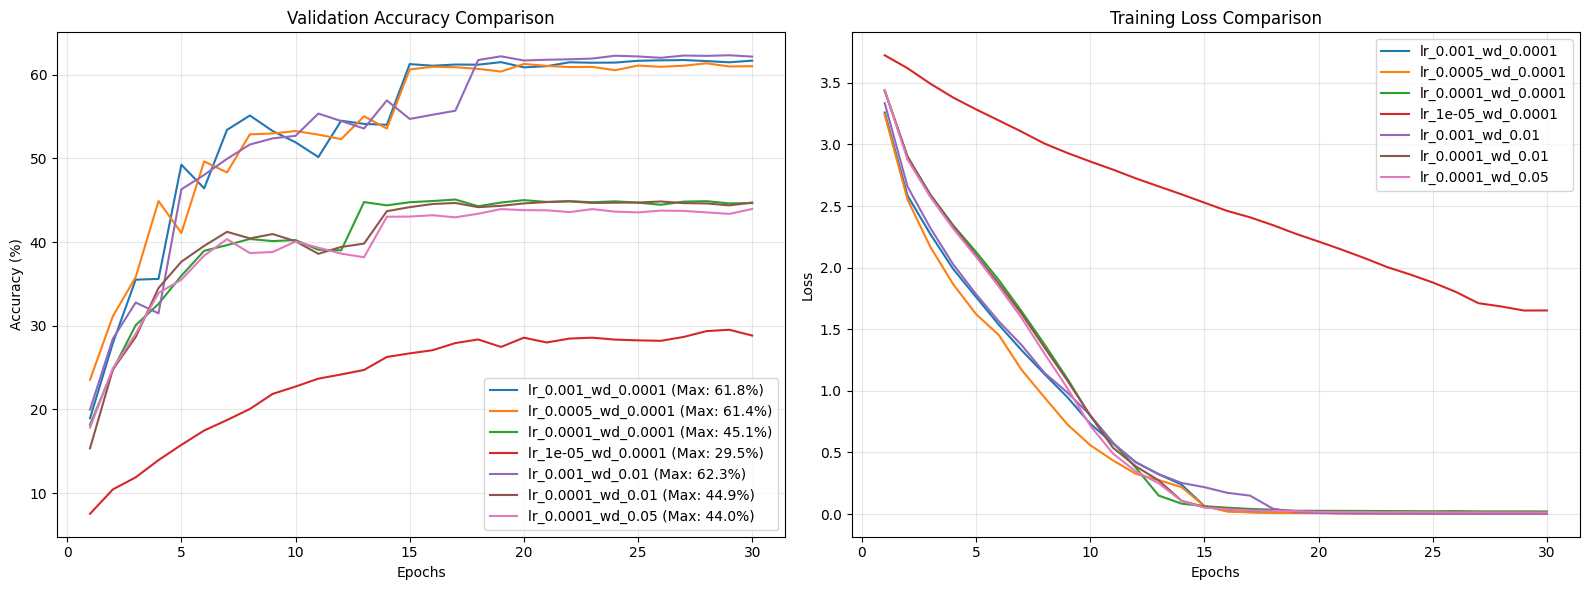

In [29]:
import shutil
import matplotlib.pyplot as plt

hyperparams_list = [
    {"lr": 1e-3, "wd": 1e-4},
    {"lr": 5e-4, "wd": 1e-4}, 
    {"lr": 1e-4, "wd": 1e-4}, 
    {"lr": 1e-5, "wd": 1e-4},
    {"lr": 1e-3, "wd": 1e-2},
    {"lr": 1e-4, "wd": 1e-2},
    {"lr": 1e-4, "wd": 5e-2},
]


EPOCHS = 30
all_histories = {}
global_best_acc = 0.0
best_params_name = ""

print(f"Starting Hyperparameter Search with {len(hyperparams_list)} configurations...")

for params in hyperparams_list:
    lr = params["lr"]
    wd = params["wd"]
    exp_name = f"lr_{lr}_wd_{wd}"
    
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(2048, NUM_CLASSES)
    model = model.to(DEVICE)
    
    trainer = SupervisedTrainer(model, train_loader, val_loader, DEVICE, lr=lr, weight_decay=wd)
    
    history, run_best_acc = trainer.train(epochs=EPOCHS, experiment_name=exp_name)
    
    all_histories[exp_name] = history
    
    if run_best_acc > global_best_acc:
        global_best_acc = run_best_acc
        best_params_name = exp_name
        print(f"New Global Best Found! ({exp_name}: {run_best_acc:.2f}%)")
        shutil.copy(f"temp_best_{exp_name}.pth", "sl_imbalanced_best.pth")

print("="*30)
print(f"Search Finished.")
print(f"Best Configuration: {best_params_name}")
print(f"Best Validation Accuracy: {global_best_acc:.2f}%")
print(f"Best model saved to 'sl_imbalanced_best.pth'")
print("="*30)

def plot_all_experiments(all_histories):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    for name, history in all_histories.items():
        epochs = range(1, len(history['val_acc']) + 1)
        best_val = max(history['val_acc'])
        plt.plot(epochs, history['val_acc'], label=f"{name} (Max: {best_val:.1f}%)")
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for name, history in all_histories.items():
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], label=name)
    
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('hyperparameter_search_results.png')
    plt.show()

plot_all_experiments(all_histories)


In [30]:
from sklearn.metrics import classification_report

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model.load_state_dict(torch.load("sl_imbalanced_best.pth"))
model.eval()
model.to(DEVICE)
print("_model_")

_model_


In [31]:
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * test_correct / test_total
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

Testing: 100%|██████████| 88/88 [00:01<00:00, 52.55it/s]


Final Test Accuracy: 61.08%


In [32]:
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


Detailed Classification Report:
                 precision    recall  f1-score   support

       antelope     0.7842    0.6943    0.7365       157
            bat     0.2115    0.1930    0.2018        57
         beaver     0.2368    0.3103    0.2687        29
     blue+whale     0.3810    0.3077    0.3404        26
         bobcat     0.4157    0.3936    0.4044        94
        buffalo     0.6791    0.6741    0.6766       135
      chihuahua     0.2714    0.2235    0.2452        85
     chimpanzee     0.4569    0.4862    0.4711       109
         collie     0.4564    0.4416    0.4488       154
            cow     0.5652    0.5821    0.5735       201
      dalmatian     0.8553    0.7927    0.8228        82
           deer     0.5372    0.6436    0.5856       202
        dolphin     0.6875    0.7746    0.7285       142
       elephant     0.7333    0.7756    0.7539       156
            fox     0.5904    0.4949    0.5385        99
german+shepherd     0.4397    0.4000    0.4189       1